<a href="https://colab.research.google.com/github/maxiuboldi/challenge_digitas/blob/main/challenge_digitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digitas - Examen DS**

## Dependencias

In [1]:
%pip install \
    category-encoders==2.6.2 \
    feature-engine==1.6.2 \
    jinja2==3.1.2 \
    lightgbm==4.1.0 \
    matplotlib==3.8.0 \
    numpy==1.26.1 \
    pandas==2.1.1 \
    scikit-learn==1.3.2 \
    scikit-plot==0.3.7 \
    seaborn==0.13.0 \
    shap==0.43.0 \
    tqdm==4.66.1 \
    xgboost==2.0.1

In [2]:
from typing import Dict, List
import time
import warnings

from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.calibration import CalibrationDisplay
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from sklearn.model_selection import train_test_split
import shap

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

from category_encoders import CatBoostEncoder
from feature_engine.imputation import EndTailImputer
from feature_engine.wrappers import SklearnTransformerWrapper

In [3]:
dataset = pd.read_csv('https://raw.githubusercontent.com/maxiuboldi/challenge_digitas/main/FlightDelays_Data_3.0%5B67%5D.csv')

In [4]:
dataset

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
0,1.0,12,814,UA,134.0,0.0,0,679.0
1,1.0,12,830,DL,90.0,0.0,0,214.0
2,1.0,1,1835,UA,213.0,0.0,0,1605.0
3,1.0,4,1730,AA,80.0,0.0,0,235.0
4,1.0,7,1442,UA,103.0,0.0,0,413.0
...,...,...,...,...,...,...,...,...
5995,0.0,6,1725,AA,115.0,17.0,30,597.0
5996,0.0,9,1945,DL,127.0,-19.0,-9,752.0
5997,0.0,8,1850,DL,101.0,6.0,-4,481.0
5998,0.0,7,1720,AA,210.0,178.0,42,1302.0


In [5]:
dataset.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Canceled,5999.0,NaN,NaN,NaN,0.166694,0.372734,0.0,0.0,0.0,0.0,1.0
Month,6000.0,NaN,NaN,NaN,6.220167,3.436325,1.0,3.0,6.0,9.0,12.0
DepartureTime,6000.0,NaN,NaN,NaN,1330.4665,459.118234,5.0,930.0,1325.0,1715.0,2359.0
UniqueCarrier,6000,3,AA,2476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SchedElapsedTime,5998.0,NaN,NaN,NaN,161.606869,78.155044,-127.0,105.0,145.0,200.0,604.0
ArrDelay,5999.0,NaN,NaN,NaN,8.108018,35.764033,-72.0,-8.0,0.0,10.0,410.0
DepDelay,6000.0,NaN,NaN,NaN,9.148833,31.669299,-16.0,-3.0,0.0,6.0,387.0
Distance,5999.0,NaN,NaN,NaN,991.190698,685.68541,-439.0,547.0,837.0,1249.0,15990.0


In [6]:
dataset.dtypes

Canceled            float64
Month                 int64
DepartureTime         int64
UniqueCarrier        object
SchedElapsedTime    float64
ArrDelay            float64
DepDelay              int64
Distance            float64
dtype: object

Se observan algunos valores ausentes en ciertas variables, pero son mínimos. Se asume que es posible que, eventualmente, en una implementación también pudieran surgir por lo que se mantienen y se procederá a su imputación.

No obstante, se observa un registro en la variable objetivo que también presenta un valor ausente. Siendo el target, se excluye ese registro.

In [7]:
dataset = dataset[~dataset['Canceled'].isna()]

Se observa un problema desbalanceado

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


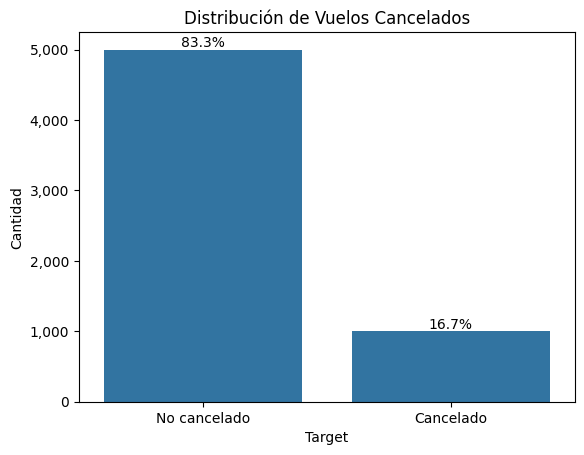

In [8]:
ax = sns.countplot(
    data=dataset,
    x='Canceled'
)
ax.set_xlabel('Target')
ax.set_ylabel('Cantidad')
ax.set_title(
    f'Distribución de Vuelos Cancelados'
)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

for p in ax.patches:
    height = p.get_height()
    percentage = (height / len(dataset)) * 100
    ax.annotate(
        text=f'{percentage:.1f}%',
        xy=(p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

ax.set_xticklabels(['No cancelado', 'Cancelado'])
plt.show()

En principio parece ser que la aerolínea DL es la que menor proporción de cancelados manifiesta y, por ende, la que menor riesgo presentaría.

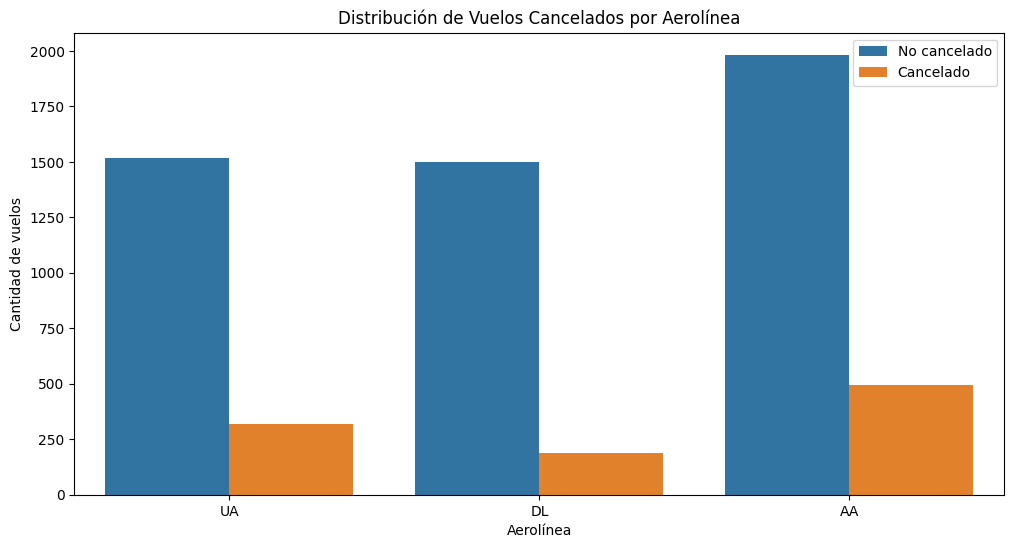

In [9]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=dataset,
    x='UniqueCarrier',
    hue='Canceled'
)

plt.title('Distribución de Vuelos Cancelados por Aerolínea')
plt.xlabel('Aerolínea')
plt.ylabel('Cantidad de vuelos')

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['No cancelado', 'Cancelado'])

plt.show()

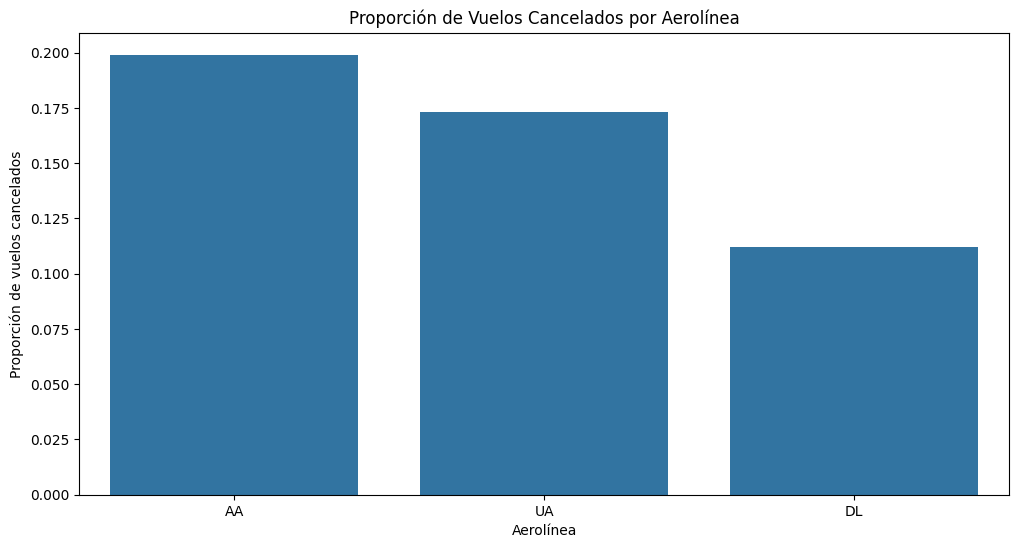

In [10]:
total_flights = dataset['UniqueCarrier'].value_counts()
canceled_flights = dataset[dataset['Canceled']
                           == 1]['UniqueCarrier'].value_counts()

proportion_canceled = (canceled_flights / total_flights).reset_index()
proportion_canceled.columns = ['UniqueCarrier', 'ProportionCanceled']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=proportion_canceled,
    x='UniqueCarrier',
    y='ProportionCanceled'
)
plt.title('Proporción de Vuelos Cancelados por Aerolínea')
plt.xlabel('Aerolínea')
plt.ylabel('Proporción de vuelos cancelados')
plt.show()

In [11]:
num_cols = list(dataset.select_dtypes(exclude=['object']).columns)

In [12]:
num_cols

['Canceled',
 'Month',
 'DepartureTime',
 'SchedElapsedTime',
 'ArrDelay',
 'DepDelay',
 'Distance']

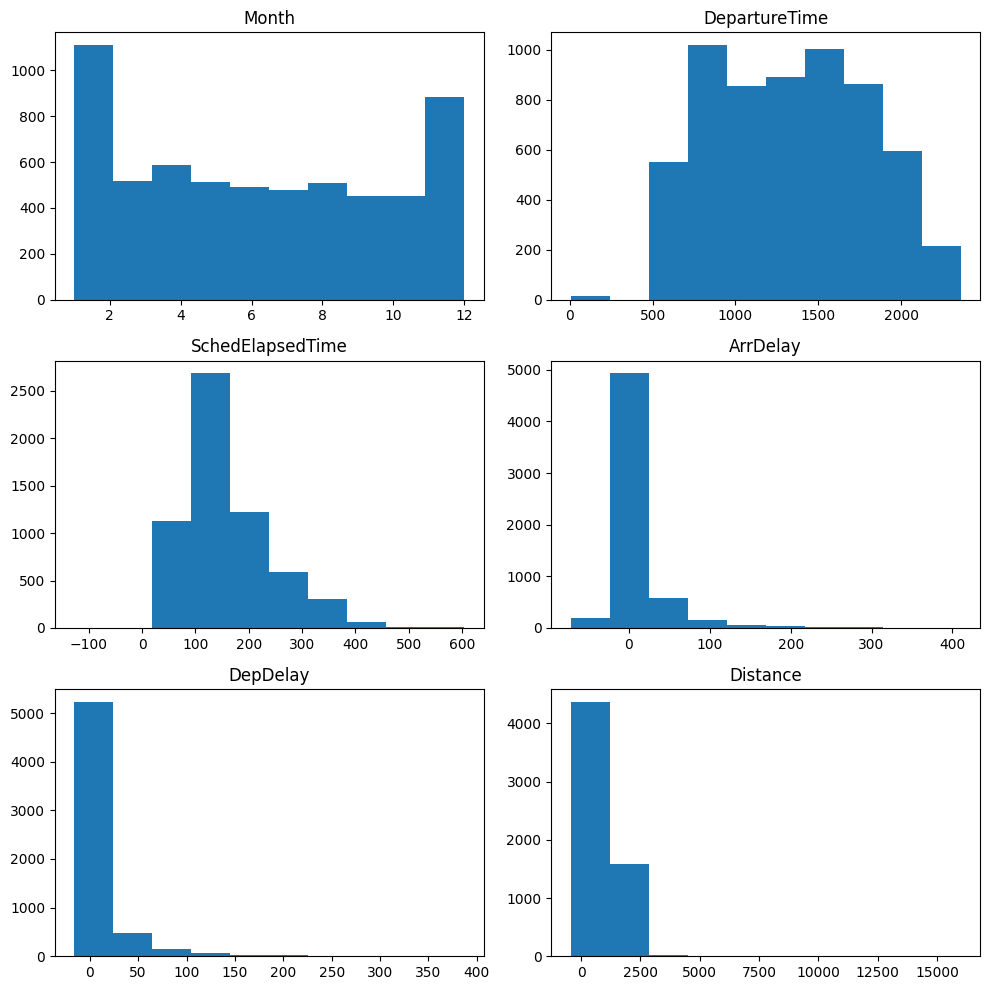

In [13]:
dataset[[x for x in num_cols if x not in ['Canceled']]].hist(
    figsize=(10, 10),
    grid=False
)
plt.tight_layout()
plt.show()

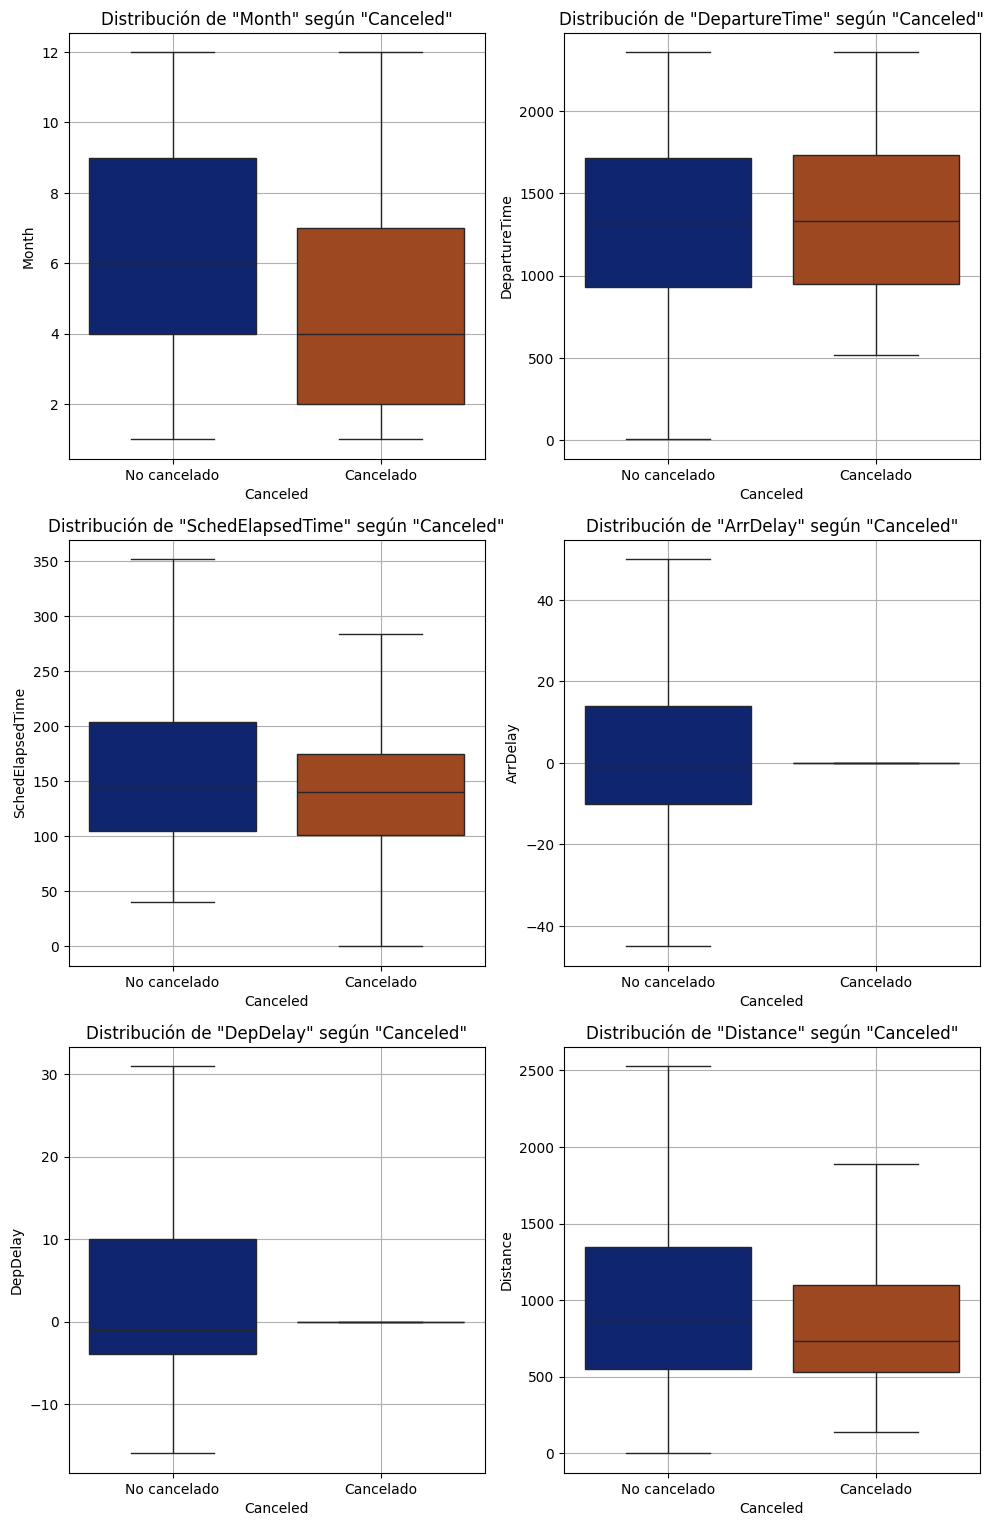

In [14]:
plt.figure(figsize=(10, 20))
for index, column in enumerate([x for x in num_cols if x not in ['Canceled']]):
    plt.subplot(math.ceil(len(num_cols)/2), 2, index+1)
    sns.boxplot(y=column, x='Canceled', hue='Canceled', data=dataset,
                palette='dark', showfliers=False, legend=False)
    plt.title('Distribución de "{}" según "Canceled"'.format(column))
    plt.xticks(ticks=[0, 1], labels=['No cancelado', 'Cancelado'])
    plt.grid()
    plt.tight_layout()


Se observan ciertos valores atípicos en las distribuciones que sugerirían profundizar en las lógicas de construcción del conjunto de datos. Por ejemplo, por qué podría producirse que el tiempo de viaje planificado (SchedElapsedTime) o la distancia (Distance) presenten valores negativos?

## Modelado

In [15]:
# Renombramos para tener identificada la variable target
dataset = dataset.rename({'Canceled': 'Target'},axis=1)

In [16]:
dataset

,Target,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
0,1.0,12,814,UA,134.0,0.0,0,679.0
1,1.0,12,830,DL,90.0,0.0,0,214.0
2,1.0,1,1835,UA,213.0,0.0,0,1605.0
3,1.0,4,1730,AA,80.0,0.0,0,235.0
4,1.0,7,1442,UA,103.0,0.0,0,413.0
...,...,...,...,...,...,...,...,...
5995,0.0,6,1725,AA,115.0,17.0,30,597.0
5996,0.0,9,1945,DL,127.0,-19.0,-9,752.0
5997,0.0,8,1850,DL,101.0,6.0,-4,481.0
5998,0.0,7,1720,AA,210.0,178.0,42,1302.0


In [17]:
'''Funciones útiles'''

def compute_metrics(
        y_true: List[float],
        y_score: List[float]
    ) -> Dict[str, float]:
    '''
    Computes various evaluation metrics based on true labels and scores.
    '''
    return {
        'roc_score': roc_auc_score(y_true, y_score),
        'ks': binary_ks_curve(y_true, y_score)[3],
        'pr_score': average_precision_score(y_true, y_score)
    }

def compute_roc_optimal_cutoff(
        y_true: List[float],
        y_score: List[float]
    ) -> float:
    '''
    Compute the optimal cutoff threshold based on the Receiver Operating
    Characteristic (ROC) curve (Youden's index).
    '''

    fpr, tpr, thresh = roc_curve(y_true, y_score)
    idx = np.arange(len(tpr))
    roc = pd.DataFrame(
        {
            'tf': pd.Series(tpr - (1 - fpr), index=idx),
            'threshold': pd.Series(thresh, index=idx)
        }
    )
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
    return float(roc_t['threshold'].values[0])

def compute_ks_optimal_cutoff(
        y_true: List[float],
        y_score: List[float]
    ) -> float:
    '''
    Compute the optimal cutoff threshold based on the Kolmogorov-Smirnov
    (KS) statistic.
    '''
    return binary_ks_curve(y_true, y_score)[4]

def compute_optimal_cutoff(
        y_true: List[float],
        y_score: List[float],
        method: str = 'ks'
    ) -> float:
    '''
    Compute the optimal cutoff threshold based on the specified method
    and test date.
    '''
    if method == 'roc':
        return compute_roc_optimal_cutoff(y_true, y_score)
    elif method == 'ks':
        return compute_ks_optimal_cutoff(y_true, y_score)
    else:
        raise ValueError(f'Unsupported method: {method}')

def plot_ks(
        y_true: List[float],
        y_score: List[float],
        figsize: tuple = (10, 6),
        test_date: str = 'N/D'
    ):
    '''
    Plot the Kolmogorov-Smirnov (KS) statistic.
    '''
    pred_scores = np.column_stack(
        (1 - y_score, y_score))

    plot_ks_statistic(
        y_true,
        pred_scores,
        title=f'Estadístico KS - {test_date}',
        figsize=figsize
    )
    plt.show()

def plot_feature_importance(
        model,
        top_n: int = 10,
        figsize: tuple = (10, 6)
    ):
    '''
    Plot the top feature importances.
    '''

    try:
        if hasattr(model, 'feature_names_in_'):
            feature_importances = pd.Series(
                model.feature_importances_ /
                model.feature_importances_.sum(),
                index=model.feature_names_in_
            )
        elif hasattr(model, 'feature_name_'):
            feature_importances = pd.Series(
                model.feature_importances_ /
                model.feature_importances_.sum(),
                index=model.feature_name_
            )
        elif hasattr(model, 'feature_names_'):
            feature_importances = pd.Series(
                model.feature_importances_ /
                model.feature_importances_.sum(),
                index=model.feature_names_
            )
        else:
            feature_importances = pd.Series(
                model.feature_importances_ /
                model.feature_importances_.sum(),
                index=[str(i) for i in range(
                    len(model.feature_importances_))]
            )
    except AttributeError:
        print(
            (
                'Cannot calculate feature importance. '
                'Is your model a decision tree object?'
            )
        )
    feature_importances = feature_importances.sort_values(ascending=False)
    top_features = feature_importances[:top_n]

    plt.figure(figsize=figsize)
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.title(f'Top {top_n} - Importancia de Variables')
    plt.show()


def plot_confusion_matrix(
        y_true: List[float],
        y_score: List[float],
        test_date='N/D',
        threshold=0.5,
        display_labels=None,
        figsize=(10, 6),
        normalize=None
    ):
    '''
    Plot the confusion matrix.
    '''

    test_target = y_true
    pred_target = np.where(y_score > threshold, 1, 0)

    disp = ConfusionMatrixDisplay.from_predictions(
        test_target,
        pred_target,
        display_labels=display_labels,
        cmap='Blues',
        values_format='.0f' if normalize is None else None,
        normalize=normalize,
        colorbar=False
    )
    disp.ax_.set_title(f"Matriz de Confusión - {test_date}")
    disp.figure_.set_size_inches(figsize)
    plt.show()

def plot_calibration_curve(
        y_true: List[float],
        y_score: List[float],
        test_date='N/D',
        figsize=(10, 6)
    ):
    '''
    Plot the calibration curve.
    '''

    plt.figure(figsize=figsize)
    disp = CalibrationDisplay.from_predictions(
        y_true,
        y_score
    )
    disp.ax_.set_title(f"Curva de Calibración - {test_date}")

    handles, labels = disp.ax_.get_legend_handles_labels()
    disp.ax_.legend(handles, labels, loc='best')

    plt.show()

def plot_shap_importance(
        model,
        train_data,
        top_n: int = 10,
        figsize: tuple = (10, 6)
    ):
    '''
    Plot the top feature importances.
    '''

    explainer = shap.TreeExplainer(
        model=model,
        feature_perturbation='tree_path_dependent',
        model_output='raw'
    )
    shap_values = explainer.shap_values(train_data)
    shap.summary_plot(
        # shap_values[1],
        shap_values,
        train_data,
        plot_type='violin',
        max_display=top_n,
        plot_size=figsize,
        show=False
    )
    plt.title(f'Importancia SHAP - Top {top_n}', fontsize=16, y=1.05)
    plt.show()

In [18]:
SEED = 8888

In [19]:
dataset_model = dataset.copy()

In [20]:
train_data, test_data, train_target, test_target = train_test_split(
    dataset_model.drop('Target', axis=1),
    dataset_model['Target'],
    test_size=0.1,
    random_state=SEED,
    stratify=dataset_model['Target']
)

In [21]:
cat_cols = list(train_data.select_dtypes(['object']).columns)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns)

In [22]:
models = [
        ('Dummy', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', DummyClassifier()
                )
            ]
        )
    ),
        ('LogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty=None,
                        solver='lbfgs',
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('LassoLogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty='l1',
                        solver='saga',
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('RidgeLogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty='l2',
                        solver='lbfgs',
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('ElasticNetLogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty='elasticnet',
                        solver='saga',
                        l1_ratio=0.5,
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('KNeighbors', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(MinMaxScaler())
                ),
                ('model', KNeighborsClassifier(n_jobs=-1),
                )
            ]
        )
    ),
        ('LightGBM', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', LGBMClassifier(
                        random_state=SEED,
                        n_jobs=-1,
                        verbose=-1
                    ),
                )
            ]
        )
    ),
        ('XGBoost', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', XGBClassifier(random_state=SEED, n_jobs=-1),
                )
            ]
        )
    ),
        ('ExtraTrees', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', ExtraTreesClassifier(
                        random_state=SEED,
                        n_jobs=-1
                    ),
                )
            ]
        )
    ),
        ('RandomForest', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', RandomForestClassifier(
                        random_state=SEED,
                        n_jobs=-1
                    ),
                )
            ]
        )
    ),
        ('SGDSVM', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', CalibratedClassifierCV(
                        SGDClassifier(
                            loss='hinge', # SVM
                            n_jobs=-1,
                            random_state=SEED
                        ),
                        method='sigmoid',
                        cv=None,
                        n_jobs=-1,
                        ensemble=True
                    )
                )
            ]
        )
    )
]

### Selección de algoritmos

In [23]:
warnings.filterwarnings('ignore', 'is_categorical_dtype')
model_metrics_list = []

for model, learner in tqdm(models, desc=r'Running Model Selection'):

    metrics_list = []
    for train_index, valid_index in StratifiedKFold(
            n_splits=5, random_state=SEED, shuffle=True
        ).split(
        train_data, train_target):

        start_time = time.time()

        train_data_fold = train_data.iloc[train_index].copy()
        train_target_fold = train_target.iloc[train_index].copy()

        val_data_fold = train_data.iloc[valid_index].copy()
        val_target_fold = train_target.iloc[valid_index].copy()

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=ConvergenceWarning)
            learner.fit(train_data_fold, train_target_fold)

        pred_target_fold = learner.predict_proba(val_data_fold)[:, -1]

        metrics_fold = compute_metrics(val_target_fold, pred_target_fold)
        metrics_fold.update({'TT_secs': time.time() - start_time})
        metrics_list.append(metrics_fold)

    metrics = pd.DataFrame(metrics_list)
    metrics.columns = metrics.columns.str.upper()
    metrics = metrics.mean().to_frame().T
    metrics.index = [model]

    model_metrics_list.append(metrics)

metrics = pd.concat(model_metrics_list).round(4)
metrics.index.name = 'MODEL'

Running Model Selection: 100%|██████████| 11/11 [00:35<00:00,  3.26s/it]


In [24]:
metrics.sort_values(
    'PR_SCORE',
    ascending=False
).style.highlight_max(
        subset=[col for col in metrics.columns if col != 'TT_SECS'],
        color='green'
    ).map(lambda x: 'background-color: gray', subset=['TT_SECS'])

,ROC_SCORE,KS,PR_SCORE,TT_SECS
MODEL,,,,
XGBoost,0.999500,0.992000,0.997000,1.659200
LightGBM,0.999300,0.993800,0.995700,1.529500
RandomForest,0.999100,0.989800,0.993700,1.362500
ExtraTrees,0.996600,0.958200,0.986300,1.062300
KNeighbors,0.699400,0.307700,0.299100,0.156400
SGDSVM,0.689000,0.308600,0.282600,0.781700
RidgeLogisticRegression,0.699700,0.321900,0.275900,0.139500
ElasticNetLogisticRegression,0.699500,0.322100,0.275500,0.205800
LogisticRegression,0.699700,0.321000,0.275200,0.072700


In [25]:
pipeline = Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', XGBClassifier(random_state=SEED, n_jobs=-1),
                )
            ]
        )

In [26]:
pipeline.fit(
    train_data,
    train_target
)
scores = pipeline.predict_proba(test_data)[:, -1]

In [27]:
metrics = compute_metrics(
    y_true=test_target,
    y_score=scores
)
for m, s in metrics.items():
    print(f'{m}: {s:.4f}')

roc_score: 0.9991
ks: 0.9920
pr_score: 0.9945


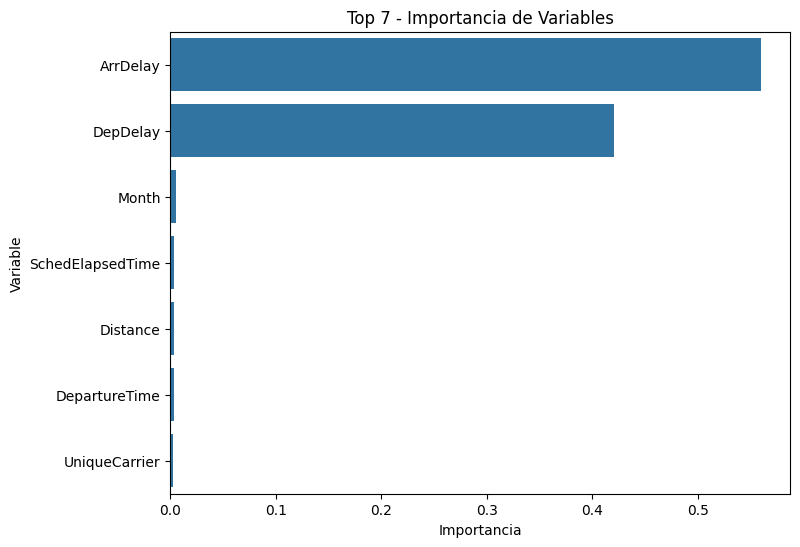

In [28]:
plot_feature_importance(
    model=pipeline['model'],
    top_n=7,
    figsize=(8, 6)
)

[20:37:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


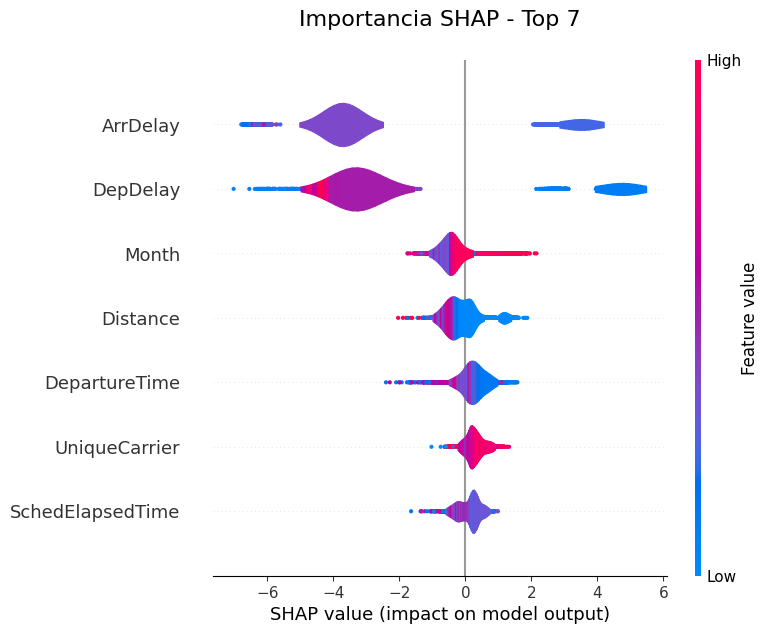

In [29]:
train_data_shap = pipeline['cat_encoder'].transform(train_data)
train_data_shap = pipeline['num_imputer'].transform(train_data_shap)
plot_shap_importance(
    model=pipeline['model'],
    train_data=train_data_shap,
    top_n=7,
    figsize=(8, 6)
)

In [30]:
# Estas variables para "predecir" no sirven porque a priori entiendo que no estarían disponibles al momento de una eventual inferencia.
dataset_model = dataset.copy()
dataset_model = dataset_model.drop(['ArrDelay', 'DepDelay'], axis=1)

In [31]:
train_data, test_data, train_target, test_target = train_test_split(
    dataset_model.drop('Target', axis=1),
    dataset_model['Target'],
    test_size=0.1,
    random_state=SEED,
    stratify=dataset_model['Target']
)

In [32]:
cat_cols = list(train_data.select_dtypes(['object']).columns)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns)

In [33]:
models = [
        ('Dummy', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', DummyClassifier()
                )
            ]
        )
    ),
        ('LogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty=None,
                        solver='lbfgs',
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('LassoLogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty='l1',
                        solver='saga',
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('RidgeLogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty='l2',
                        solver='lbfgs',
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('ElasticNetLogisticRegression', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', LogisticRegression(
                        penalty='elasticnet',
                        solver='saga',
                        l1_ratio=0.5,
                        random_state=SEED
                    )
                )
            ]
        )
    ),
        ('KNeighbors', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(MinMaxScaler())
                ),
                ('model', KNeighborsClassifier(n_jobs=-1),
                )
            ]
        )
    ),
        ('LightGBM', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', LGBMClassifier(
                        random_state=SEED,
                        n_jobs=-1,
                        verbose=-1
                    ),
                )
            ]
        )
    ),
        ('XGBoost', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', XGBClassifier(random_state=SEED, n_jobs=-1),
                )
            ]
        )
    ),
        ('ExtraTrees', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', ExtraTreesClassifier(
                        random_state=SEED,
                        n_jobs=-1
                    ),
                )
            ]
        )
    ),
        ('RandomForest', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('model', RandomForestClassifier(
                        random_state=SEED,
                        n_jobs=-1
                    ),
                )
            ]
        )
    ),
        ('SGDSVM', Pipeline(
            steps=[
                ('cat_encoder', CatBoostEncoder(
                        drop_invariant=True,
                        random_state=SEED,
                        cols=cat_cols,
                    )
                ),
                ('num_imputer', EndTailImputer(
                        imputation_method='iqr',
                        tail='left',
                        fold=5,
                        variables=num_cols
                    )
                ),
                ('scaler', SklearnTransformerWrapper(StandardScaler())
                ),
                ('model', CalibratedClassifierCV(
                        SGDClassifier(
                            loss='hinge', # SVM
                            n_jobs=-1,
                            random_state=SEED
                        ),
                        method='sigmoid',
                        cv=None,
                        n_jobs=-1,
                        ensemble=True
                    )
                )
            ]
        )
    )
]

In [34]:
warnings.filterwarnings('ignore', 'is_categorical_dtype')
model_metrics_list = []

for model, learner in tqdm(models, desc=r'Running Model Selection'):

    metrics_list = []
    for train_index, valid_index in StratifiedKFold(
            n_splits=5, random_state=SEED, shuffle=True
        ).split(
        train_data, train_target):

        start_time = time.time()

        train_data_fold = train_data.iloc[train_index].copy()
        train_target_fold = train_target.iloc[train_index].copy()

        val_data_fold = train_data.iloc[valid_index].copy()
        val_target_fold = train_target.iloc[valid_index].copy()

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=ConvergenceWarning)
            learner.fit(train_data_fold, train_target_fold)

        pred_target_fold = learner.predict_proba(val_data_fold)[:, -1]

        metrics_fold = compute_metrics(val_target_fold, pred_target_fold)
        metrics_fold.update({'TT_secs': time.time() - start_time})
        metrics_list.append(metrics_fold)

    metrics = pd.DataFrame(metrics_list)
    metrics.columns = metrics.columns.str.upper()
    metrics = metrics.mean().to_frame().T
    metrics.index = [model]

    model_metrics_list.append(metrics)

metrics = pd.concat(model_metrics_list).round(4)
metrics.index.name = 'MODEL'

Running Model Selection: 100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


In [35]:
metrics.sort_values(
    'PR_SCORE',
    ascending=False
).style.highlight_max(
        subset=[col for col in metrics.columns if col != 'TT_SECS'],
        color='green'
    ).map(lambda x: 'background-color: gray', subset=['TT_SECS'])

,ROC_SCORE,KS,PR_SCORE,TT_SECS
MODEL,,,,
LightGBM,0.661400,0.261900,0.267300,0.129100
LogisticRegression,0.647800,0.263700,0.258400,0.070000
LassoLogisticRegression,0.647600,0.265900,0.257600,0.102900
ElasticNetLogisticRegression,0.647600,0.265000,0.257600,0.104200
RidgeLogisticRegression,0.647700,0.265500,0.257500,0.071000
RandomForest,0.647500,0.228100,0.254000,0.820200
XGBoost,0.648800,0.241500,0.252600,0.835400
SGDSVM,0.639100,0.247300,0.252200,0.165900
ExtraTrees,0.632400,0.227900,0.234000,0.735400


## Conclusiones

El problema en cuestión se define principalmente por 2 variables, ArrDelay (retraso en el arribo) y DepDelay (retraso en la partida). Estas 2 variables por si solas tienen una relación directa con la variable objetivo (cancelaciones). Según el análisis preliminar, valores bajos en estas variables parecen presentar una mayor correlación con el target. Excluyendo estas variables el problema en cuestión no parece ser explicado por las restantes y el modelado no se vuelve aconsejable.

La principal pregunta acerca de un posible modelo productivo respecto de esta cuestión, sería, estas variables estarían disponibles al momento de una eventual predicción? o son variables recolectadas en forma posterior que no podrían utilizarse en la práctica posteriormente?